In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import timm
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from facenet_pytorch import MTCNN
import sys
import os
from tqdm import tqdm

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=2, bias=False)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 16, 5, padding=2, bias=False)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, 5, padding=2, bias=False)
        self.bn4 = nn.BatchNorm2d(16)
        self.flatten_dim = 16 * 16 * 16
        self.fc1 = nn.Linear(self.flatten_dim, 16)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class EfficientNetDF(nn.Module):
    def __init__(self, num_classes=2, pretrained=False):
        super(EfficientNetDF, self).__init__()
        self.model = models.efficientnet_b0(weights=None) 
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(num_features, num_classes)
        )
    def forward(self, x):
        return self.model(x)

In [4]:
class EfficientNetDF(nn.Module):
    def __init__(self, num_classes=2, pretrained=False):
        super(EfficientNetDF, self).__init__()
        self.model = models.efficientnet_b0(weights=None) 
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(num_features, num_classes)
        )
    def forward(self, x):
        return self.model(x)

In [5]:
class Resnet18DF(nn.Module):
    def __init__(self, num_classes = 2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = models.resnet18(weights="IMAGENET1K_V1")
        num_ftrs = self.model.fc.in_features
        params = list(self.model.parameters())
        for param in params:
            param.requires_grad = False
            
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, X):
        return self.model(X)

In [6]:
class XceptionDF(nn.Module):
    def __init__(self, num_classes = 2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = timm.create_model("xception", pretrained=True)
        num_ftrs = self.model.fc.in_features
        for param in self.model.parameters():
            param.requires_grad = False # Freeze base model
            
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, X):
        return self.model(X)

In [7]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.handle = target_layer.register_forward_hook(self.save_activation_and_hook)

    def save_activation_and_hook(self, module, input, output):
        self.activations = output
        output.register_hook(self.save_gradient)

    def save_gradient(self, grad):
        self.gradients = grad

    def __call__(self, x, class_idx=None):
        self.gradients = None 
        self.activations = None
        
        # 1. Forward Pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)
            
        # 2. Backward Pass
        self.model.zero_grad()
        target = output[:, class_idx]
        target.backward(retain_graph=True)
        
        # 3. Check if we caught data
        if self.gradients is None or self.activations is None:
            print("Warning: Grad-CAM failed to capture gradients. Check target_layer or requires_grad.")
            return np.zeros((x.shape[2], x.shape[3]), dtype=np.float32), 0.0
        
        # 4. Generate Map
        gradients = self.gradients.data.cpu().numpy()[0]
        activations = self.activations.data.cpu().numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
            
        cam = np.maximum(cam, 0) # ReLU
        cam = cv2.resize(cam, (x.shape[2], x.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)
        
        # Thresholding to reduce noise
        cam[cam < 0.2] = 0 
        
        return cam, torch.softmax(output, dim=1)[0][1].item()
    
    def remove_hooks(self):
        self.handle.remove()

In [8]:
class FaceCropper:
    def __init__(self, device='cpu'):
        # MTCNN for robust face detection
        self.mtcnn = MTCNN(keep_all=False, select_largest=True, device=device, margin=20)

    def crop(self, pil_image):
        """
        Detects face and returns the cropped PIL Image.
        Returns None if no face detected.
        """
        try:
            face_tensor = self.mtcnn(pil_image)
            
            if face_tensor is not None:
                boxes, _ = self.mtcnn.detect(pil_image)
                if boxes is not None:
                    box = boxes[0]
                    x1, y1, x2, y2 = [int(b) for b in box]
                    width, height = pil_image.size
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(width, x2)
                    y2 = min(height, y2)
                    
                    return pil_image.crop((x1, y1, x2, y2))
            return None
        except Exception as e:
            print(f"Face detection error: {e}")
            return None

In [9]:
def get_preprocessing(model_name):
    model_name = model_name.lower()
    
    if model_name in ['simplecnn', 'simple_cnn']: 
        IMG_SIZE = (256, 256)
    elif model_name == "xception":
        IMG_SIZE = (299, 299)
    else:
        IMG_SIZE = (224, 224)
        
    return transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
             std=[0.229, 0.224, 0.225]
        )
    ])

In [10]:
def denormalize(tensor):
    """
    Reverts normalization to display original image correctly
    """
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
         std=[1/s for s in std])
    img = inv_normalize(tensor)
    img = img.permute(1, 2, 0).cpu().numpy()
    return np.clip(img, 0, 1)

In [11]:
def load_and_crop_content(file_path, num_frames=10, device='cpu'):
    cropper = FaceCropper(device)
    ext = os.path.splitext(file_path)[1].lower()
    
    raw_frames = []
    
    # Extract Raw Frames
    if ext in ['.jpg', '.png', '.jpeg']:
        raw_frames = [Image.open(file_path).convert('RGB')]
    elif ext in ['.mp4', '.avi', '.mov', '.mkv', '.webm', '.gif']:
        cap = cv2.VideoCapture(file_path)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total > 0:
            indices = np.linspace(0, total-1, num_frames, dtype=int)
            for i in indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if ret:
                    raw_frames.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
        cap.release()
    else:
        print(f"Error: File type {ext} not supported.")
        return []

    # Crop Faces & Keep Original
    final_data = [] # Stores tuples: (original_pil, cropped_pil)
    
    print(f"Extracted {len(raw_frames)} frames. Cropping faces...")
    for frame in raw_frames:
        face = cropper.crop(frame)
        if face is not None:
            final_data.append((frame, face))
            
    if len(final_data) == 0:
        print("Warning: No faces detected! Using full frames.")
        # Fallback: Use full frame as both original and crop so code doesn't break
        return [(f, f) for f in raw_frames]
    
    print(f"Successfully cropped {len(final_data)} faces.")
    return final_data

In [12]:
def pipeline(input_path, model_path, model_name, device='cpu'):
    # 1. Load Data
    frames = load_and_crop_conddtent(input_path, num_frames=15, device=device)
    if not frames: return

    # 2. Load Model
    print(f"Loading {model_name}...")
    model_name_lower = model_name.lower()
    if model_name_lower == 'simplecnn':
        model = SimpleCNN(num_classes=2)
        target_layer = model.conv4
        
    elif model_name_lower == 'efficientnet':
        model = EfficientNetDF(num_classes=2, pretrained=False)
        target_layer = model.model.features[-1]
        
    elif model_name_lower == 'xception':
        model = XceptionDF(num_classes=2)
        target_layer = model.model.conv4
    
    elif model_name_lower == 'resnet':
        model = Resnet18DF(num_classes=2)
        target_layer = model.model.layer4[-1]
        
    else:
        print(f"Model Not Supported.")
        return
        
    try:
        checkpoint = torch.load(model_path, map_location=device)
        sd = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
        model.load_state_dict(sd)
    except Exception as e:
        print(f"Model Load Error: {e}")
        return
    
    model.to(device).eval()
    
    # 3. Analyze
    grad_cam = GradCAM(model, target_layer)
    preprocess = get_preprocessing(model_name)
    probs = []
    vis_data = None
    vis_idx = len(frames) // 2

    for i, frame in tqdm(enumerate(frames), desc="Running Inference"):
        input_tensor = preprocess(frame).unsqueeze(0).to(device)
        
        # Get Heatmap for FAKE class (Index 1)
        heatmap, prob_fake = grad_cam(input_tensor, class_idx=1)
        probs.append(prob_fake)
        
        if i == vis_idx:
            orig = denormalize(input_tensor[0].cpu())
            hmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
            hmap_color = cv2.cvtColor(hmap_color, cv2.COLOR_BGR2RGB)
            hmap_color = np.float32(hmap_color) / 255
            
            # Weighting: 50% image, 50% heatmap
            overlay = 0.5 * orig + 0.5 * hmap_color
            vis_data = (orig, np.clip(overlay, 0, 1))

    # 4. Results
    avg_fake_prob = np.mean(probs)
    prediction = "FAKE" if avg_fake_prob > 0.5 else "REAL"
    conf = avg_fake_prob if prediction == "FAKE" else 1 - avg_fake_prob
    
    print(f"\n>>> FINAL PREDICTION: {prediction}")
    print(f">>> Confidence: {conf*100:.2f}%")
    
    # 5. Visualize
    if vis_data:
        plt.figure(figsize=(12, 6))
        
        # Cropped Face
        plt.subplot(1, 2, 1)
        plt.imshow(vis_data[0])
        plt.title(f"Face Crop\n(Input to Model)")
        plt.axis('off')
        
        # Attention Map
        plt.subplot(1, 2, 2)
        plt.imshow(vis_data[1])
        plt.title(f"Grad-CAM Focus Area\nPred: {prediction}")
        plt.axis('off')
        
        plt.suptitle(f'Predicting using {model_name}')
        plt.tight_layout()
        plt.show()

In [13]:
def pipeline(input_path, model_path, model_name, device='cpu'):
    # Load Data
    data_pairs = load_and_crop_content(input_path, num_frames=15, device=device)
    if not data_pairs: return

    # Load Model
    print(f"Loading {model_name}...")
    model_name = model_name.lower()
    
    # Model Selection Logic
    if model_name in ['simplecnn', 'simple_cnn']:
        model = SimpleCNN(num_classes=2)
        target_layer = model.conv4
    elif model_name == 'efficientnet':
        model = EfficientNetDF(num_classes=2, pretrained=False)
        target_layer = model.model.features[-1]
    elif model_name == 'xception':
        model = XceptionDF(num_classes=2)
        # timm Xception usually uses 'conv4' as the final block before classifier
        target_layer = model.model.conv4 
    elif model_name == 'resnet':
        model = Resnet18DF(num_classes=2)
        target_layer = model.model.layer4[-1]
    else:
        print(f"Model {model_name} Not Supported.")
        return
        
    try:
        checkpoint = torch.load(model_path, map_location=device)
        sd = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
        model.load_state_dict(sd)
    except Exception as e:
        print(f"Model Load Error: {e}")
        return
    
    model.to(device).eval()
    
    # Init GradCAM
    grad_cam = GradCAM(model, target_layer)
    preprocess = get_preprocessing(model_name)
    probs = []
    vis_data = None
    vis_idx = len(data_pairs) // 2

    for i, (orig_frame, cropped_frame) in tqdm(enumerate(data_pairs), desc="Running Inference"):
        # CRITICAL FIX: requires_grad_(True)
        # Since your base models (Xception/ResNet) might be frozen, we MUST force
        # PyTorch to build a computation graph from the input image.
        input_tensor = preprocess(cropped_frame).unsqueeze(0).to(device).requires_grad_(True)
        
        heatmap, prob_fake = grad_cam(input_tensor, class_idx=1)
        probs.append(prob_fake)
        
        if i == vis_idx:
            denorm_crop = denormalize(input_tensor[0].detach().cpu()) # detach needed here
            
            hmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
            hmap_color = cv2.cvtColor(hmap_color, cv2.COLOR_BGR2RGB)
            hmap_color = np.float32(hmap_color) / 255
            
            overlay = 0.5 * denorm_crop + 0.5 * hmap_color
            vis_data = (orig_frame, denorm_crop, np.clip(overlay, 0, 1))

    # Results
    avg_fake_prob = np.mean(probs)
    prediction = "FAKE" if avg_fake_prob > 0.5 else "REAL"
    conf = avg_fake_prob if prediction == "FAKE" else 1 - avg_fake_prob
    
    print(f"\n>>> FINAL PREDICTION: {prediction}")
    print(f">>> Confidence: {conf*100:.2f}%")
    
    # Visualize
    if vis_data:
        full_orig, face_crop, cam_overlay = vis_data
        plt.figure(figsize=(18, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(full_orig)
        plt.title(f"Original Frame", fontsize=12)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(face_crop)
        plt.title(f"Face Crop (Model Input)", fontsize=12)
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(cam_overlay)
        plt.title(f"Grad-CAM\nPred: {prediction}", fontsize=12, fontweight='bold', color='red' if prediction=='FAKE' else 'green')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cuda


In [15]:
def run_prediction(input_file, model_file, model_name, device):
    if os.path.exists(input_file) and os.path.exists(model_file):
        pipeline(input_file, model_file, model_name, device)
    else:
        print("File path incorrect. Please check INPUT_FILE and MODEL_FILE.")

In [16]:
REAL = '../data/real/005/086.png'
FAKE = '../data/fake/FaceShifter/003_000/058.png'

In [17]:
SIMPLECNN = '../model_checkpoints/simplecnn.pth'
EFFICIENTNET = '../model_checkpoints/efficientnet.pth'
XCEPTION = '../model_checkpoints/xception.pth'
RESNET = '../model_checkpoints/resnet.pth'

Extracted 1 frames. Cropping faces...
Successfully cropped 1 faces.
Loading EfficientNet...


Running Inference: 1it [00:00,  3.40it/s]



>>> FINAL PREDICTION: REAL
>>> Confidence: 96.95%


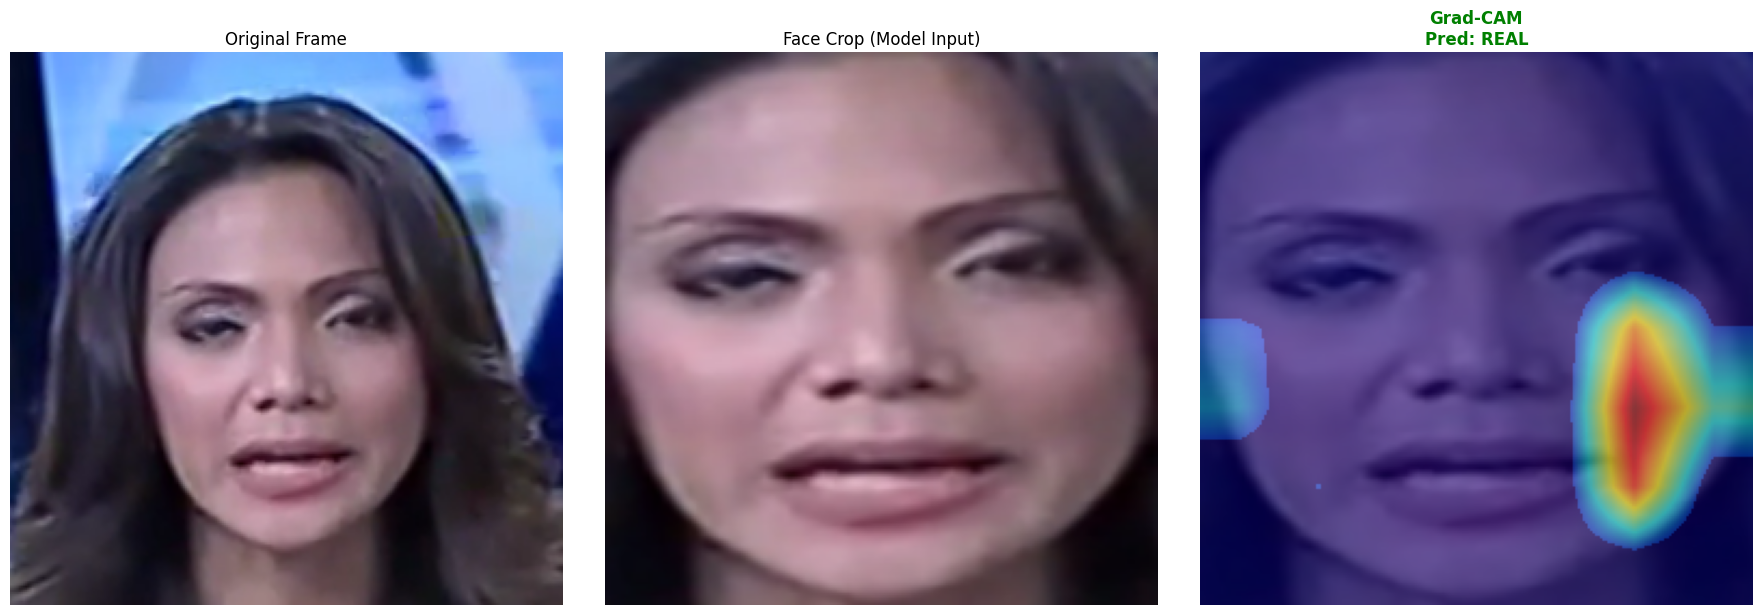

In [18]:
run_prediction(REAL, EFFICIENTNET, "EfficientNet", DEVICE)

Extracted 1 frames. Cropping faces...
Successfully cropped 1 faces.
Loading EfficientNet...


Running Inference: 1it [00:00, 13.66it/s]



>>> FINAL PREDICTION: FAKE
>>> Confidence: 74.15%


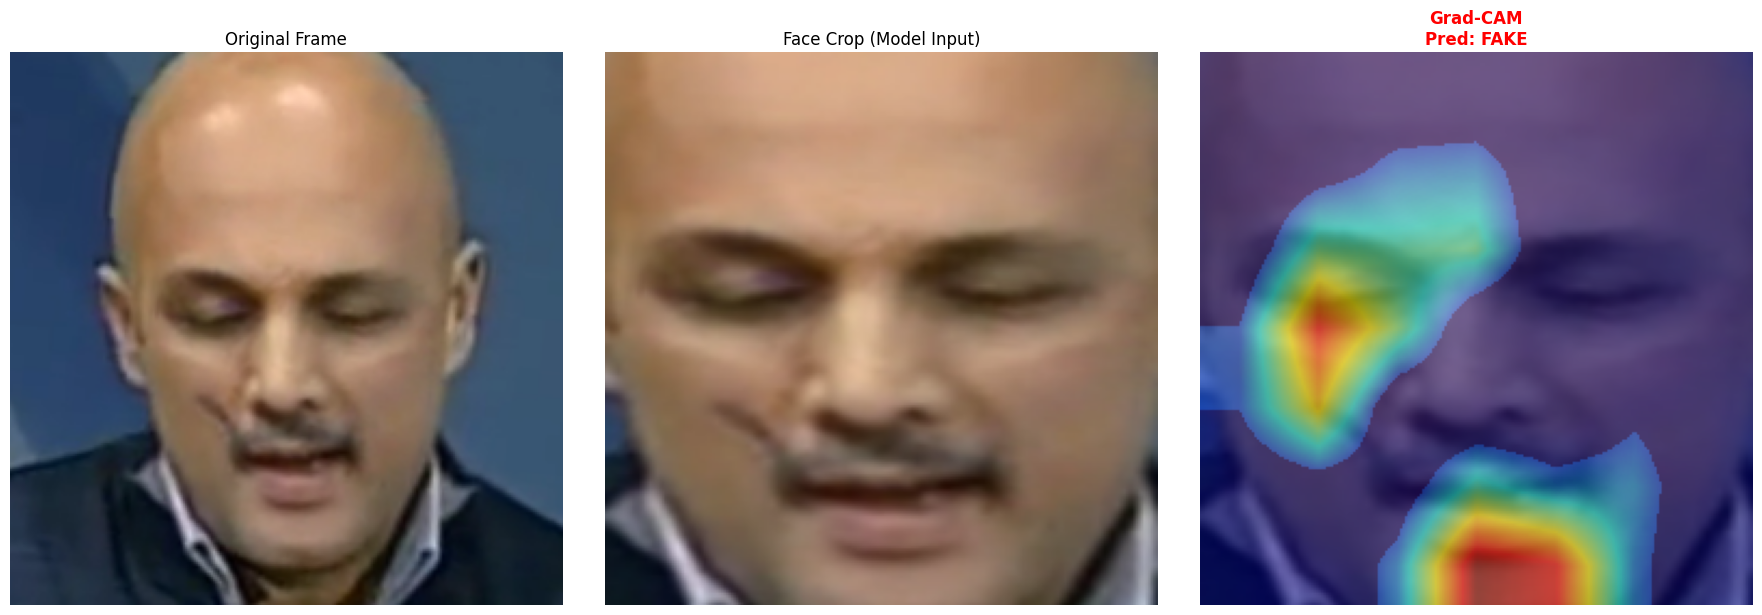

In [19]:
run_prediction(FAKE, EFFICIENTNET, "EfficientNet", DEVICE)

Extracted 1 frames. Cropping faces...
Successfully cropped 1 faces.
Loading Xception...


Running Inference: 1it [00:00,  9.00it/s]



>>> FINAL PREDICTION: REAL
>>> Confidence: 95.65%


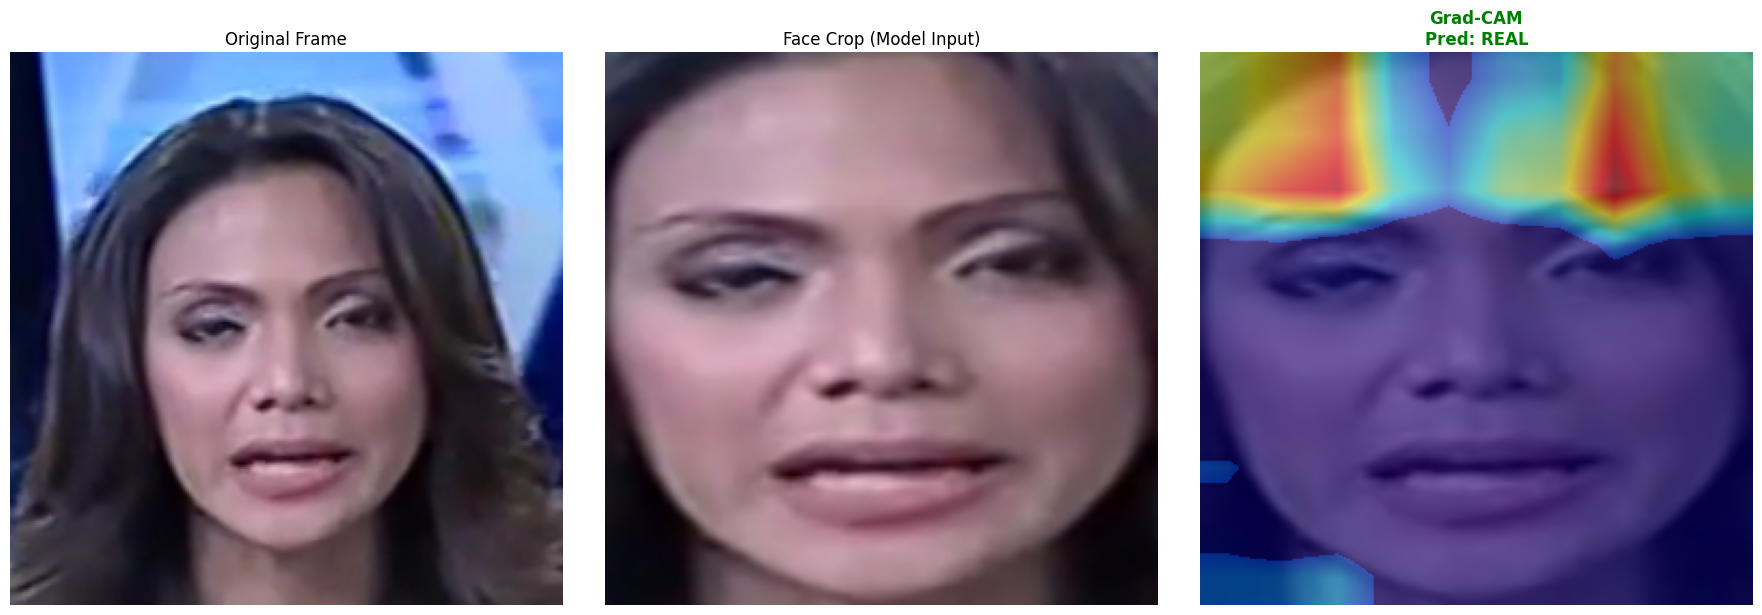

In [20]:
run_prediction(REAL, XCEPTION, "Xception", DEVICE)

Extracted 1 frames. Cropping faces...
Successfully cropped 1 faces.
Loading Xception...


Running Inference: 1it [00:00, 18.14it/s]



>>> FINAL PREDICTION: FAKE
>>> Confidence: 60.26%


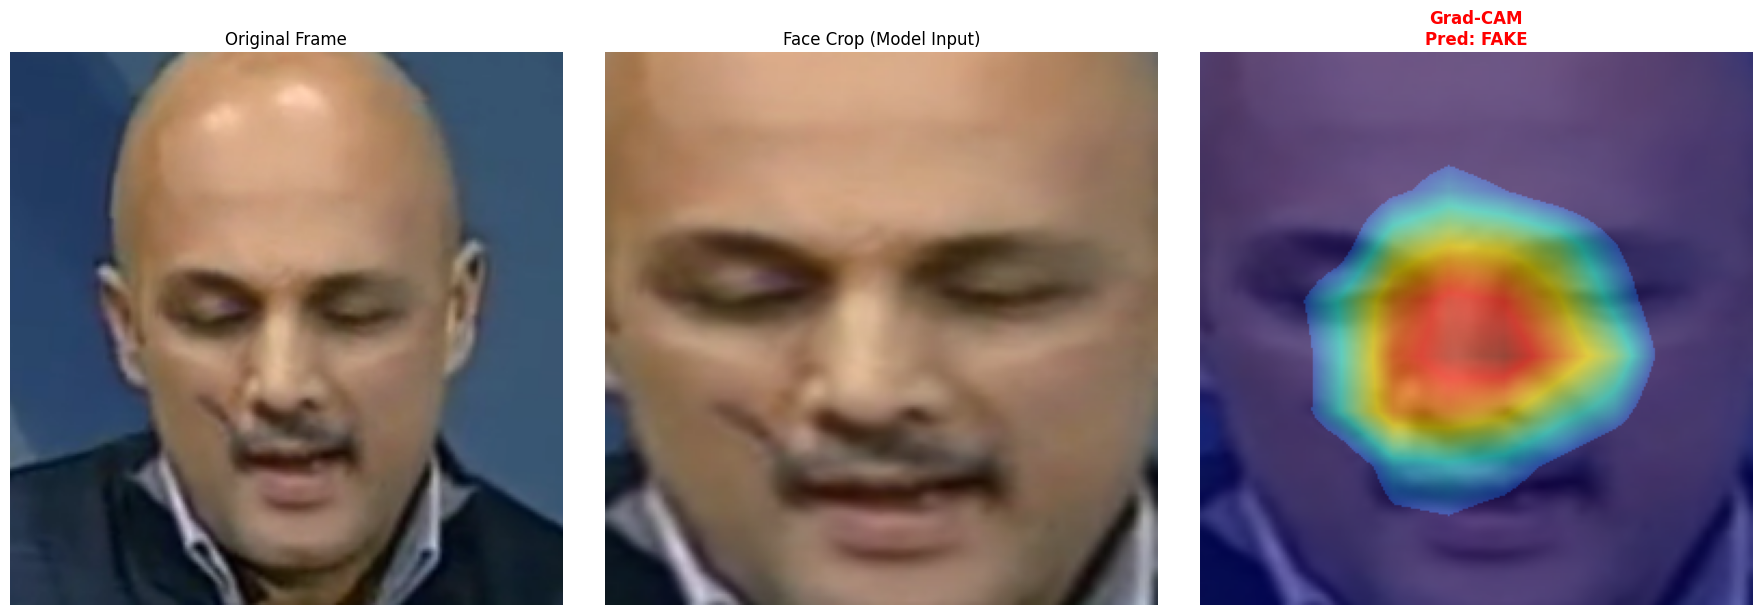

In [21]:
run_prediction(FAKE, XCEPTION, "Xception", DEVICE)

Extracted 1 frames. Cropping faces...
Successfully cropped 1 faces.
Loading ResNet...


Running Inference: 1it [00:00, 19.60it/s]



>>> FINAL PREDICTION: REAL
>>> Confidence: 99.08%


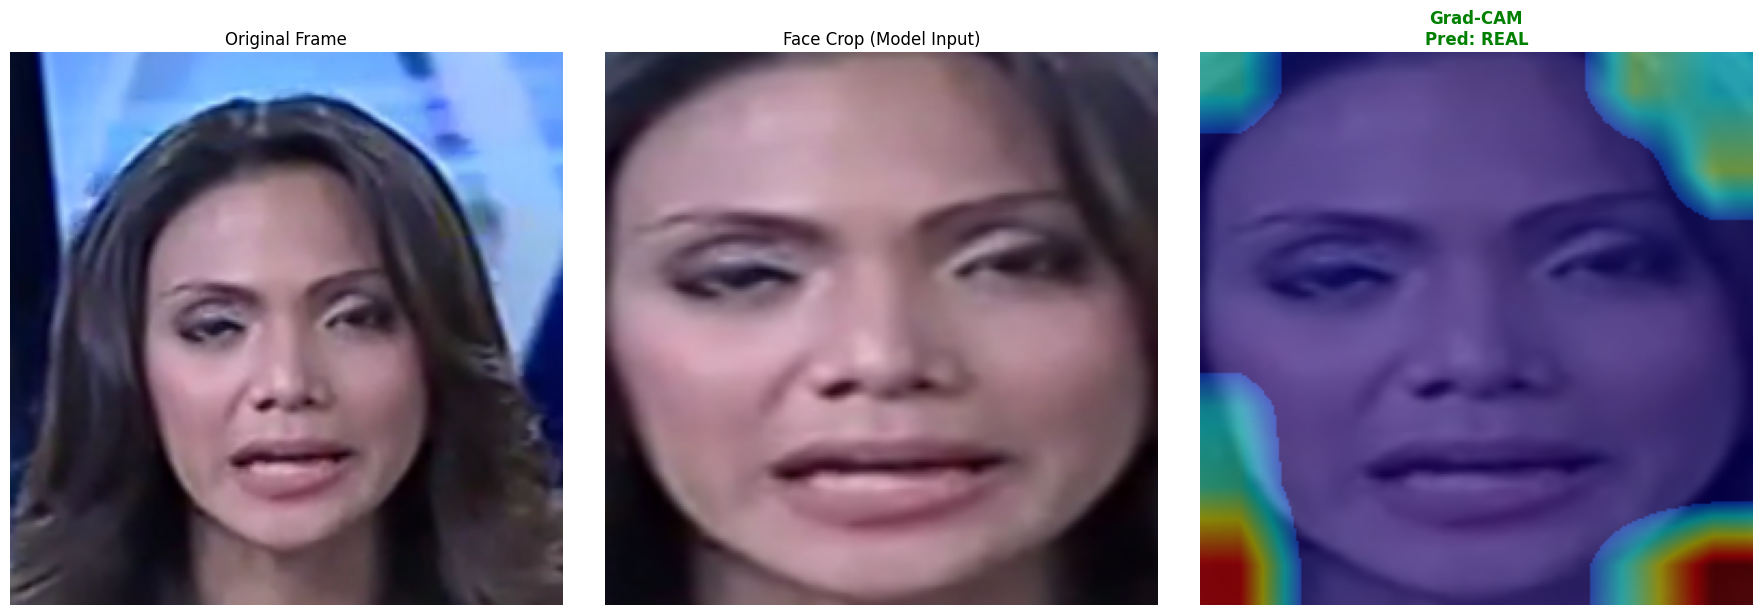

In [22]:
run_prediction(REAL, RESNET, "ResNet", DEVICE)

Extracted 1 frames. Cropping faces...
Successfully cropped 1 faces.
Loading ResNet...


Running Inference: 1it [00:00, 39.02it/s]



>>> FINAL PREDICTION: FAKE
>>> Confidence: 93.32%


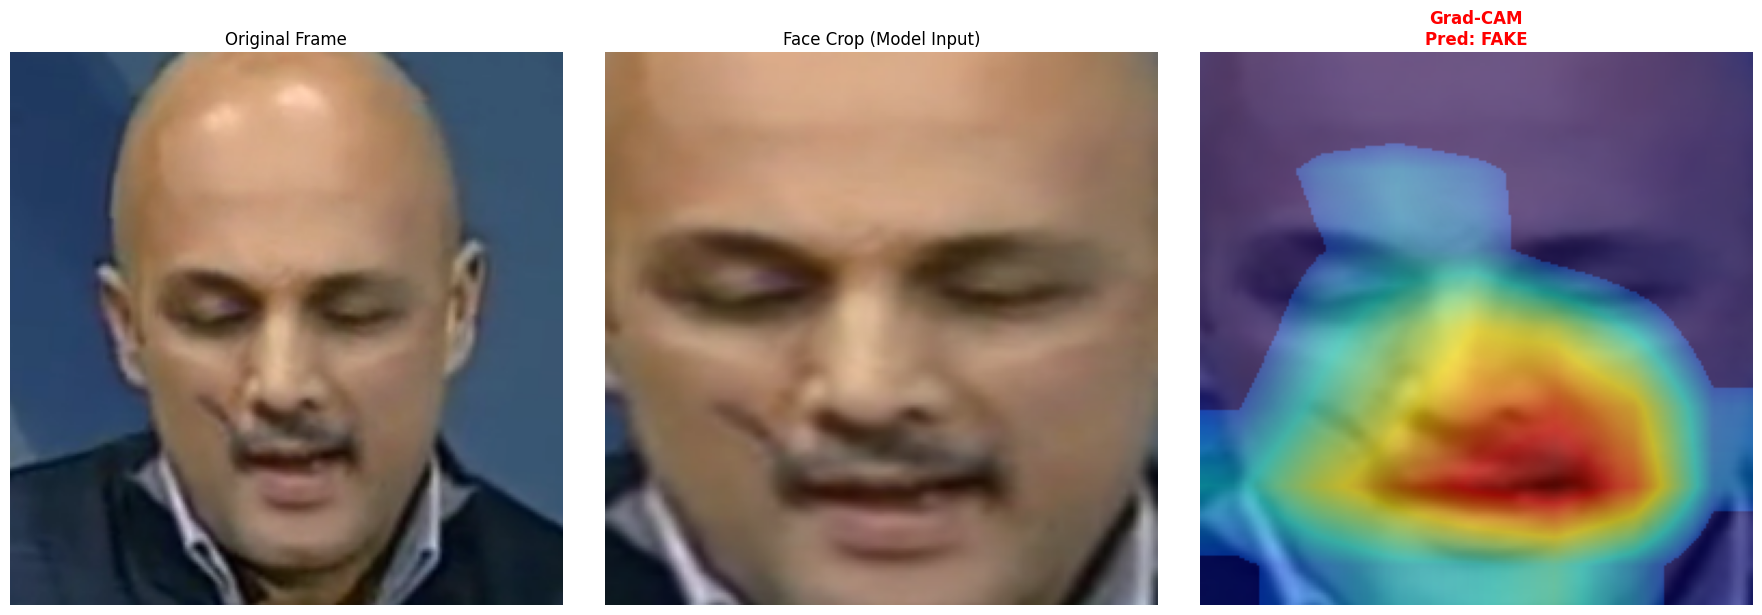

In [23]:
run_prediction(FAKE, RESNET, "ResNet", DEVICE)

Extracted 1 frames. Cropping faces...
Successfully cropped 1 faces.
Loading SimpleCNN...


Running Inference: 1it [00:00, 20.53it/s]


>>> FINAL PREDICTION: REAL
>>> Confidence: 55.08%


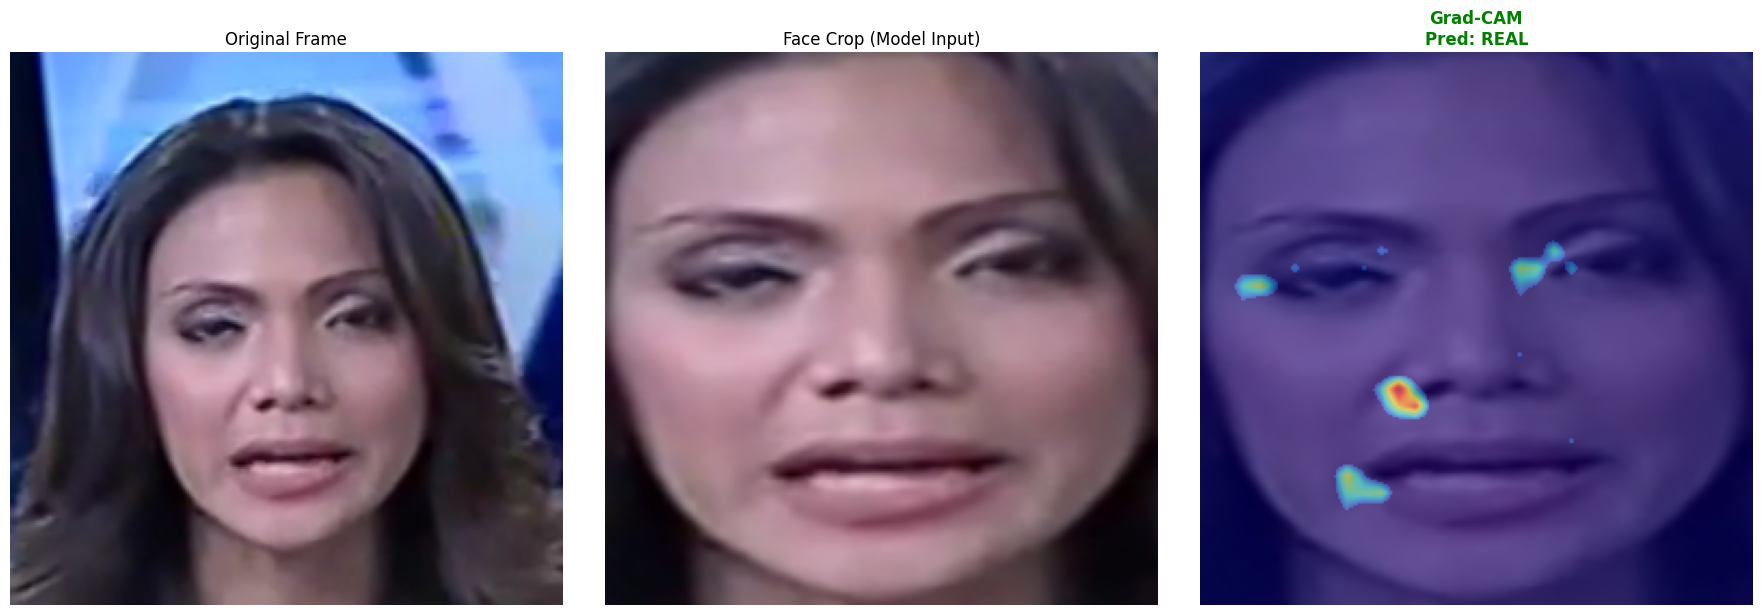

In [24]:
run_prediction(REAL, SIMPLECNN, "SimpleCNN", DEVICE)

Extracted 1 frames. Cropping faces...
Successfully cropped 1 faces.
Loading SimpleCNN...


Running Inference: 1it [00:00, 77.18it/s]


>>> FINAL PREDICTION: FAKE
>>> Confidence: 58.18%


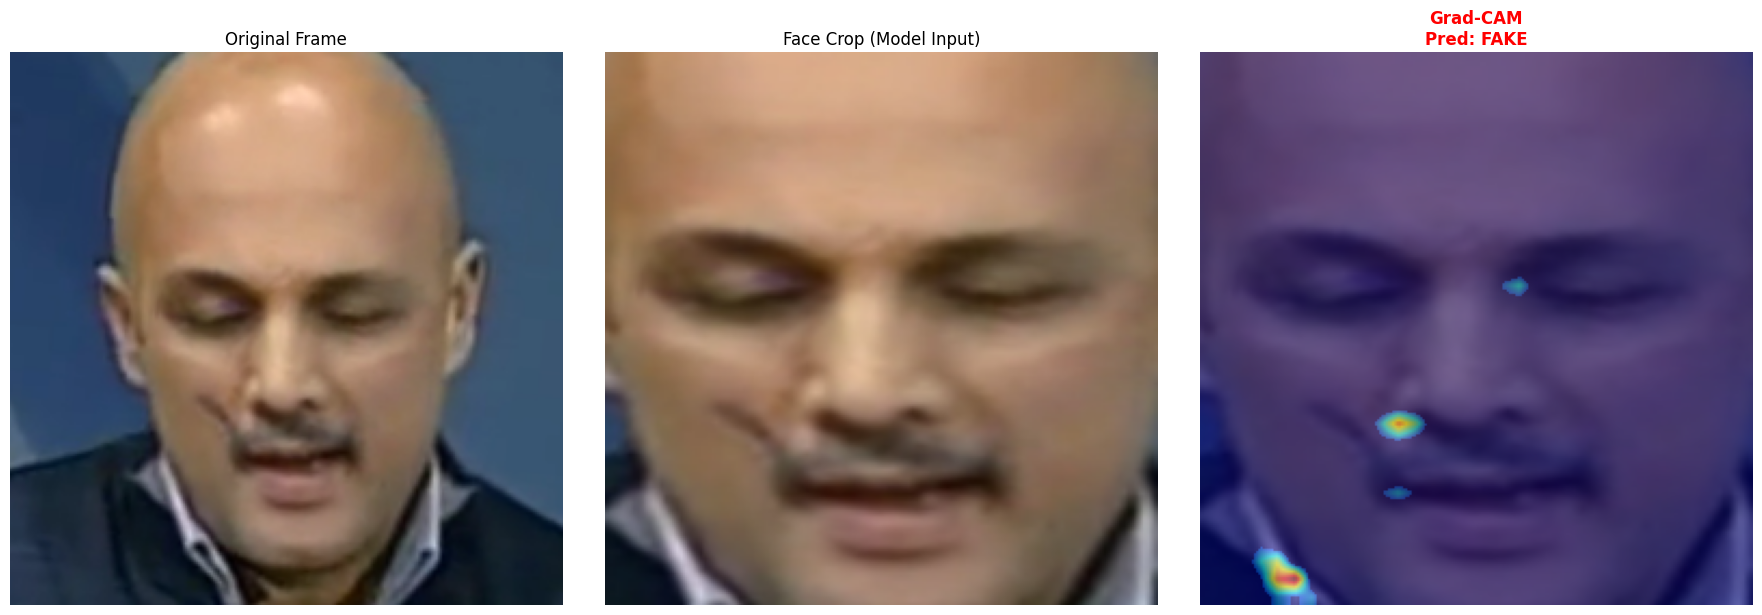

In [25]:
run_prediction(FAKE, SIMPLECNN, "SimpleCNN", DEVICE)